In [98]:
from sqlalchemy import create_engine
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# DATA INGESTION

In [3]:
def fetch_table(database, table):
    try:
        user = "postgres"
        password = "password"
        host = "localhost"
        port = 5432

        connection_string = f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}'
        engine = create_engine(connection_string)

        query = f"SELECT * FROM {table};"

        df = pd.read_sql(query, engine)

        return df
    
    except Exception as error:
        print(f"Error fetching data from table '{table}' in database '{database}': {error}")
        return None

In [4]:
route_df = fetch_table("td_raw_data", "routes_table")
route_weather_df = fetch_table("td_raw_data", "routes_weather")
traffic_table_df = fetch_table("td_raw_data", "traffic_table")

In [70]:
trucks_df = fetch_table("td_raw_data", "trucks_table")
drivers_df = fetch_table("td_raw_data", "drivers_table")


In [81]:
trucks_schedule_df = fetch_table("td_raw_data", "truck_schedule_table")

In [5]:
route_df.head()

,route_id,origin_id,destination_id,distance,average_hours
0,R-ada2a391,C-927ceb5e,C-56e39a5e,1735.06,34.70
1,R-ae0ef31f,C-927ceb5e,C-73ae5412,1498.24,29.96
2,R-4beec5fd,C-927ceb5e,C-4fe0fa24,6078.46,121.57
3,R-8d7a7fb2,C-927ceb5e,C-451776b7,1543.01,30.86
4,R-b236e347,C-927ceb5e,C-d80a1e7d,310.75,6.22


In [6]:
route_weather_df.columns.tolist()

['route_id',
 'Date',
 'temp',
 'wind_speed',
 'description',
 'precip',
 'humidity',
 'visibility',
 'pressure',
 'chanceofrain',
 'chanceoffog',
 'chanceofsnow',
 'chanceofthunder']

In [7]:
traffic_table_df.head()

,route_id,date,hour,no_of_vehicles,accident
0,R-ada2a391,2019-01-01,0,669.0,0
1,R-ada2a391,2019-01-01,100,628.0,0
2,R-ada2a391,2019-01-01,200,516.0,0
3,R-ada2a391,2019-01-01,300,582.0,0
4,R-ada2a391,2019-01-01,400,564.0,0


DATA CLEANING

In [8]:
# Routes table
route_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2352 entries, 0 to 2351
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   route_id        2352 non-null   object 
 1   origin_id       2352 non-null   object 
 2   destination_id  2352 non-null   object 
 3   distance        2352 non-null   float64
 4   average_hours   2352 non-null   float64
dtypes: float64(2), object(3)
memory usage: 92.0+ KB


Text(0.5, 1.0, 'Boxplot of Velocity')

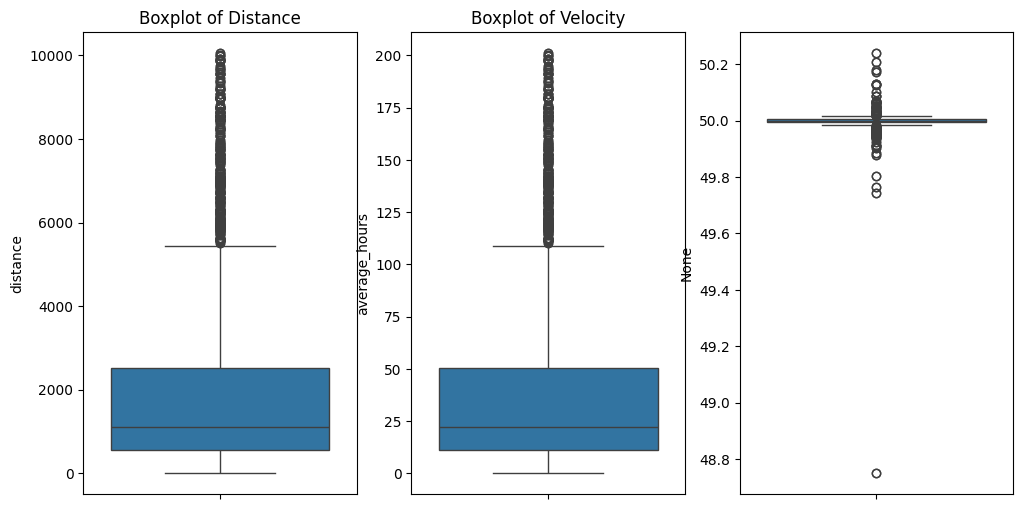

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(12, 6))

sns.boxplot(y=route_df['distance'], ax=axes[0])
axes[0].set_title('Boxplot of Distance')

sns.boxplot(y=route_df['average_hours'], ax=axes[1])
axes[1].set_title('Boxplot of Average Hours')

sns.boxplot(y=route_df['distance']/route_df['average_hours'], ax=axes[2])
axes[1].set_title('Boxplot of Velocity')

when looked at distance and spped it looks like this data doesnt have any anomalies
but velocity box plot clearly shows an anomaly 

In [10]:
def computeUpperFence( df_col, up=True ):
    """
    Computes the upper/lower fence for a given column.
    Params:
        df_col: Pandas series, dataframe column
        up: boolean, True for upper fence, False for lower fence
    Return:
        upper/lower fence value : float
    """
    iqr = df_col.quantile(.75) - df_col.quantile(.25) # inter quartile range
    if up:
        return df_col.quantile(.75) + iqr*1.5
    return df_col.quantile(.25) - iqr*3   

In [12]:
route_df['velocity'] = route_df['distance']/route_df['average_hours']
route_df[route_df['velocity'] == min(route_df['velocity'])]

,route_id,origin_id,destination_id,distance,average_hours,velocity
984,R-1b7d2dcc,C-01660979,C-2bd47dc5,3.9,0.08,48.75
1220,R-3bc91a35,C-2bd47dc5,C-01660979,3.9,0.08,48.75


Maybe that specific route is bad(its not an anomaly)

In [71]:
# route_weather_df
route_weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425712 entries, 0 to 425711
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   route_id         425712 non-null  object 
 1   Date             425712 non-null  object 
 2   temp             425712 non-null  int64  
 3   wind_speed       425712 non-null  int64  
 4   description      425712 non-null  object 
 5   precip           425712 non-null  float64
 6   humidity         425712 non-null  int64  
 7   visibility       425712 non-null  int64  
 8   pressure         425712 non-null  int64  
 9   chanceofrain     425712 non-null  int64  
 10  chanceoffog      425712 non-null  int64  
 11  chanceofsnow     425712 non-null  int64  
 12  chanceofthunder  425712 non-null  int64  
dtypes: float64(1), int64(9), object(3)
memory usage: 42.2+ MB


In [82]:
route_weather_df['Date'] = pd.to_datetime(route_weather_df['Date'], errors='coerce')
route_weather_df.sort_values(by='Date')
route_weather_df.head()

,route_id,Date,temp,wind_speed,description,precip,humidity,visibility,pressure,chanceofrain,chanceoffog,chanceofsnow,chanceofthunder
0,R-ada2a391,2019-01-01 00:00:00,30,11,Heavy snow,0.0,90,1,1010,0,0,0,0
1,R-ada2a391,2019-01-01 06:00:00,30,11,Heavy snow,0.0,91,3,1012,0,0,0,0
2,R-ada2a391,2019-01-02 00:00:00,28,11,Cloudy,0.0,91,4,1013,0,0,0,0
3,R-ada2a391,2019-01-02 06:00:00,27,11,Cloudy,0.0,92,6,1015,0,0,0,0
4,R-ada2a391,2019-01-03 00:00:00,27,9,Cloudy,0.0,93,6,1016,0,0,0,0


In [49]:
# route_weather_df.groupby(route_weather_df['description']).count()

In [23]:
route_weather_df['description'].unique()

array(['Heavy snow', 'Cloudy', 'Partly cloudy', 'Sunny', 'Mist', 'Clear',
       'Overcast', 'Fog', 'Light drizzle', 'Moderate rain', 'Heavy rain',
       'Blizzard', 'Light snow', 'Patchy light snow',
       'Patchy moderate snow', 'Moderate snow',
       'Moderate or heavy snow showers', 'Light rain',
       'Patchy heavy snow', 'Thundery outbreaks possible',
       'Moderate or heavy rain with thunder', 'Light sleet',
       'Light rain shower', 'Freezing fog', 'Heavy freezing drizzle',
       'Moderate or heavy sleet', 'Patchy rain possible',
       'Moderate or heavy rain shower', 'Moderate rain at times',
       'Blowing snow', 'Patchy snow possible', 'Patchy sleet possible',
       'Freezing drizzle', 'Patchy light rain with thunder',
       'Patchy light rain', 'Heavy rain at times', 'Patchy light drizzle',
       'Torrential rain shower', 'Ice pellets',
       'Moderate or heavy freezing rain', 'Light freezing rain',
       'Moderate or heavy snow with thunder',
       'Patchy

In [26]:
# Function to classify condition and intensity
def classify_weather(description):
    intensity_mapping = {
        1: ['Light', 'Patchy light'],
        2: ['Moderate', 'Patchy moderate', 'Moderate or heavy'],
        3: ['Heavy', 'Torrential'],
        4: ['with thunder', 'Thundery outbreaks possible'],
    }
    
    condition_mapping = {
        'Snow': ['snow', 'Blowing snow', 'Freezing drizzle', 'sleet'],
        'Rain': ['drizzle', 'rain', 'Rain shower'],
        'Fog': ['fog'],
        'Cloudy': ['Cloudy', 'Overcast'],
        'Clear': ['Clear', 'Sunny'],
        'Thunderstorms': ['thunder', 'Thundery outbreaks'],
        'Ice': ['ice', 'freezing', 'Ice pellets']
    }
    
    intensity = 0
    condition = 'Unknown'  # Default condition if not explicitly found
    
    for key, values in intensity_mapping.items():
        if any(val.lower() in description.lower() for val in values):
            intensity = key
            break
    
    for key, values in condition_mapping.items():
        if any(val.lower() in description.lower() for val in values):
            condition = key
            break
    
    return pd.Series([condition, intensity])

In [25]:
route_weather_df[['condition', 'intensity']] = route_weather_df['description'].apply(classify_weather)
route_weather_df.columns

Index(['route_id', 'Date', 'temp', 'wind_speed', 'description', 'precip',
       'humidity', 'visibility', 'pressure', 'chanceofrain', 'chanceoffog',
       'chanceofsnow', 'chanceofthunder', 'condition', 'intensity'],
      dtype='object')

In [33]:
route_weather_df.drop(['description', 'chanceofrain', 'chanceoffog', 'chanceofsnow', 'chanceofthunder'], axis=1, inplace=True)


In [34]:
route_weather_df.columns

Index(['route_id', 'Date', 'temp', 'wind_speed', 'precip', 'humidity',
       'visibility', 'pressure', 'condition', 'intensity'],
      dtype='object')

In [71]:
trucks_df.head()
drivers_df.head()

,driver_id,name,gender,age,experience,driving_style,ratings,vehicle_no,average_speed_mph
0,d9f30553-6,Daniel Marks,male,47,5,proactive,7,42302347,62.22
1,82de7bb8-2,Clifford Carr,male,47,14,proactive,4,27867488,60.89
2,7e789842-4,Terry Faulkner MD,male,41,9,conservative,2,13927774,53.67
3,b2555587-8,Brendan Jacobs,male,44,10,proactive,2,69577118,59.82
4,b2e58421-d,Vincent Davis,male,41,10,proactive,7,28650047,62.65


In [72]:
# trucks_df
trucks_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   truck_id              1300 non-null   int64  
 1   truck_age             1300 non-null   int64  
 2   load_capacity_pounds  1243 non-null   float64
 3   mileage_mpg           1300 non-null   int64  
 4   fuel_type             1300 non-null   object 
dtypes: float64(1), int64(3), object(1)
memory usage: 50.9+ KB


In [75]:
trucks_df.fillna({'load_capacity_pounds': trucks_df['load_capacity_pounds'].mean()}, inplace=True)

In [76]:
# trucks_df['mileage_mpg'] = pd.to_numeric(trucks_df['mileage_mpg'], errors='coerce')
trucks_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   truck_id              1300 non-null   int64  
 1   truck_age             1300 non-null   int64  
 2   load_capacity_pounds  1300 non-null   float64
 3   mileage_mpg           1300 non-null   int64  
 4   fuel_type             1300 non-null   object 
dtypes: float64(1), int64(3), object(1)
memory usage: 50.9+ KB


In [80]:
trucks_df.head()

,truck_id,truck_age,load_capacity_pounds,mileage_mpg,fuel_type
0,42302347,10,3000.0,17,gas
1,27867488,14,10000.0,22,diesel
2,13927774,8,10000.0,19,gas
3,69577118,8,20000.0,19,gas
4,28650047,10,4000.0,21,diesel


In [92]:
trucks_df['fuel_type'].unique()

array(['gas', 'diesel', ''], dtype=object)

In [95]:
trucks_df.groupby('fuel_type').count()

,truck_id,truck_age,load_capacity_pounds,mileage_mpg
fuel_type,,,,
,40,40,40,40
diesel,692,692,692,692
gas,568,568,568,568


In [79]:
drivers_df.head()

,driver_id,name,gender,age,experience,driving_style,ratings,vehicle_no,average_speed_mph
0,d9f30553-6,Daniel Marks,male,47,5,proactive,7,42302347,62.22
1,82de7bb8-2,Clifford Carr,male,47,14,proactive,4,27867488,60.89
2,7e789842-4,Terry Faulkner MD,male,41,9,conservative,2,13927774,53.67
3,b2555587-8,Brendan Jacobs,male,44,10,proactive,2,69577118,59.82
4,b2e58421-d,Vincent Davis,male,41,10,proactive,7,28650047,62.65


In [88]:
def upload_dataframe_to_postgres(dataframe, database, table_name, if_exists='replace'):
    try:
        user = "postgres"      
        password = "password"  
        host = "localhost"     
        port = 5432            

        # Connection string
        connection_string = f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}'
        engine = create_engine(connection_string)

        # Upload dataframe to the PostgreSQL table
        dataframe.to_sql(table_name, engine, if_exists=if_exists, index=False)

        print(f"Dataframe successfully uploaded to table '{table_name}' in database '{database}'.")

    except Exception as error:
        print(f"Error uploading dataframe to table '{table_name}' in database '{database}': {error}")

In [91]:
upload_dataframe_to_postgres(trucks_df, "td_clean_data", "trucks_table")
upload_dataframe_to_postgres(drivers_df, "td_clean_data", "drivers_table")
upload_dataframe_to_postgres(route_df, "td_clean_data", "route_table")
upload_dataframe_to_postgres(route_weather_df, "td_clean_data", "route_weather_table")
upload_dataframe_to_postgres(traffic_table_df, "td_clean_data", "traffic_table")
upload_dataframe_to_postgres(trucks_schedule_df, "td_clean_data", "trucks_schedule_table")




Dataframe successfully uploaded to table 'trucks_table' in database 'td_clean_data'.
Dataframe successfully uploaded to table 'drivers_table' in database 'td_clean_data'.
Dataframe successfully uploaded to table 'route_table' in database 'td_clean_data'.
Dataframe successfully uploaded to table 'route_weather_table' in database 'td_clean_data'.
Dataframe successfully uploaded to table 'traffic_table' in database 'td_clean_data'.
Dataframe successfully uploaded to table 'trucks_schedule_table' in database 'td_clean_data'.


In [96]:
len(trucks_schedule_df)

12308

In [97]:
sum(trucks_schedule_df['delay'])

4294